In [1]:
%load_ext autoreload
%autoreload 2

# Imports and definitions

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime
import xarray as xr

In [ ]:
from emg_from_lfp import compute_emg
from ecephys.data import channel_groups, paths
from ecephys.sglx_utils import load_timeseries

In [4]:
EMG_OPTS = dict(target_sf=20, window_size=25.0, wp=[300, 600], ws=[275, 625], gpass=1, gstop=60, ftype='butter')

In [5]:
def run_emg_pipeline_on_file(bin_path, emg_path, emg_chans):
    emg_sig = load_timeseries(bin_path, emg_chans, xarray=True)
    emg_values = compute_emg(emg_sig.values.T, emg_sig.fs, **EMG_OPTS).T
    emg_times = np.linspace(np.min(emg_sig.time), np.max(emg_sig.time), len(emg_values))
    emg = xr.DataArray(emg_values.flatten(), dims="time", coords={"time": emg_times})
    emg.attrs['long_name'] = 'EMG'
    emg.attrs['units'] = 'zero-lag correlation'
    for key in EMG_OPTS:
        emg.attrs[key] = EMG_OPTS[key]
    emg_ds = xr.Dataset({"emg": emg})
    emg_ds.to_netcdf(emg_path)
    emg_ds.close()

In [6]:
def run_emg_pipeline_on_condition(subject, condition):
    emg_chans = channel_groups.emg[subject]
    
    bin_paths = paths.get_sglx_style_datapaths(subject=subject, condition=condition, ext="lf.bin")
    emg_paths = paths.get_sglx_style_datapaths(subject=subject, condition=condition, ext="emg.nc")

    for bin_path, emg_path in zip(bin_paths, emg_paths):
        run_emg_pipeline_on_file(bin_path, emg_path, emg_chans)
        current_time = datetime.now().strftime("%H:%M:%S")
        print(f"{current_time}: Finished {str(bin_path)}")

# Run automated pipeline

### Valentino

In [9]:
run_emg_pipeline_on_condition(subject="Segundo", condition="recovery-sleep-6h")

nChan: 385, nFileSamp: 18000001
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0, LFP nchans = 3




Done!
18:18:50: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX2-Segundo/raw/1-21-2020_g0/1-21-2020_g0_imec0/1-21-2020_g0_t23.imec0.lf.bin
nChan: 385, nFileSamp: 18000001
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0, LFP nchans = 3




Done!
18:42:50: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX2-Segundo/raw/1-21-2020_g0/1-21-2020_g0_imec0/1-21-2020_g0_t24.imec0.lf.bin
nChan: 385, nFileSamp: 18000001
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0, LFP nchans = 3




Done!
18:57:23: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX2-Segundo/raw/1-21-2020_g0/1-21-2020_g0_imec0/1-21-2020_g0_t25.imec0.lf.bin


### Valentino

In [8]:
run_emg_pipeline_on_condition(subject="Valentino", condition="recovery-sleep-6h")

nChan: 385, nFileSamp: 18000000
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0, LFP nchans = 3




Done!
17:10:01: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX3-Valentino/raw/2-20-2020_g0/2-20-2020_g0_imec0/2-20-2020_g0_t3.imec0.lf.bin
nChan: 385, nFileSamp: 18000000
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0, LFP nchans = 3




Done!
17:20:35: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX3-Valentino/raw/2-20-2020_g0/2-20-2020_g0_imec0/2-20-2020_g0_t4.imec0.lf.bin
nChan: 385, nFileSamp: 18000000
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0, LFP nchans = 3




Done!
17:29:53: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX3-Valentino/raw/2-20-2020_g0/2-20-2020_g0_imec0/2-20-2020_g0_t5.imec0.lf.bin


### Doppio

In [7]:
run_emg_pipeline_on_condition(subject="Doppio", condition="recovery-sleep-6h")

nChan: 385, nFileSamp: 18000019
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0025140000002, LFP nchans = 3




Done!
17:31:10: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX4-Doppio/raw/3-18-2020_g0/3-18-2020_g0_imec0/3-18-2020_g0_t3.imec0.lf.bin
nChan: 385, nFileSamp: 18000019
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0025140000002, LFP nchans = 3




Done!
17:41:49: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX4-Doppio/raw/3-18-2020_g0/3-18-2020_g0_imec0/3-18-2020_g0_t4.imec0.lf.bin
nChan: 385, nFileSamp: 18000019
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0025140000002, LFP nchans = 3




Done!
17:49:56: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX4-Doppio/raw/3-18-2020_g0/3-18-2020_g0_imec0/3-18-2020_g0_t5.imec0.lf.bin


### Alessandro

In [8]:
run_emg_pipeline_on_condition(subject="Alessandro", condition="extended-wake")

nChan: 385, nFileSamp: 9000051
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0141365, LFP nchans = 3




Done!
13:14:19: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX5-Alessandro/raw/8-25-2020_SD_g0/8-25-2020_SD_g0_imec0/8-25-2020_SD_g0_t0.imec0.lf.bin
nChan: 385, nFileSamp: 9000052
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0141365, LFP nchans = 3




Done!
13:18:32: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX5-Alessandro/raw/8-25-2020_SD_g0/8-25-2020_SD_g0_imec0/8-25-2020_SD_g0_t1.imec0.lf.bin
nChan: 385, nFileSamp: 8127109
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0141365, LFP nchans = 3




Done!
13:22:34: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX5-Alessandro/raw/8-25-2020_SD_g0/8-25-2020_SD_g0_imec0/8-25-2020_SD_g0_t2.imec0.lf.bin
nChan: 385, nFileSamp: 8277840
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0141365, LFP nchans = 3




Done!
13:26:44: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX5-Alessandro/raw/8-25-2020_SD2_g0/8-25-2020_SD2_g0_imec0/8-25-2020_SD2_g0_t0.imec0.lf.bin
nChan: 385, nFileSamp: 9000052
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0141365, LFP nchans = 3




Done!
13:31:22: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX5-Alessandro/raw/8-25-2020_g0/8-25-2020_g0_imec0/8-25-2020_g0_t0.imec0.lf.bin
nChan: 385, nFileSamp: 9000052
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0141365, LFP nchans = 3




Done!
13:35:35: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX5-Alessandro/raw/8-25-2020_g0/8-25-2020_g0_imec0/8-25-2020_g0_t1.imec0.lf.bin


In [10]:
run_emg_pipeline_on_condition(subject="Alessandro", condition="recovery-sleep-6h")

nChan: 385, nFileSamp: 9000052
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0141365, LFP nchans = 3




Done!
12:35:01: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX5-Alessandro/raw/8-25-2020_g0/8-25-2020_g0_imec0/8-25-2020_g0_t2.imec0.lf.bin
nChan: 385, nFileSamp: 9000052
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0141365, LFP nchans = 3




Done!
12:42:21: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX5-Alessandro/raw/8-25-2020_g0/8-25-2020_g0_imec0/8-25-2020_g0_t3.imec0.lf.bin
nChan: 385, nFileSamp: 9000051
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0141365, LFP nchans = 3




Done!
12:47:59: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX5-Alessandro/raw/8-25-2020_g0/8-25-2020_g0_imec0/8-25-2020_g0_t4.imec0.lf.bin
nChan: 385, nFileSamp: 9000052
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0141365, LFP nchans = 3




Done!
12:51:29: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX5-Alessandro/raw/8-25-2020_g0/8-25-2020_g0_imec0/8-25-2020_g0_t5.imec0.lf.bin
nChan: 385, nFileSamp: 9000052
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0141365, LFP nchans = 3




Done!
12:54:56: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX5-Alessandro/raw/8-25-2020_g0/8-25-2020_g0_imec0/8-25-2020_g0_t6.imec0.lf.bin
nChan: 385, nFileSamp: 9000052
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0141365, LFP nchans = 3




Done!
12:58:59: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX5-Alessandro/raw/8-25-2020_g0/8-25-2020_g0_imec0/8-25-2020_g0_t7.imec0.lf.bin


### Eugene

In [7]:
run_emg_pipeline_on_condition(subject="Eugene", condition="extended-wake")

nChan: 385, nFileSamp: 800217
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
12:44:40: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SD_24hs_g0/9.24.2020_SD_24hs_g0_imec0/9.24.2020_SD_24hs_g0_t0.imec0.lf.bin
nChan: 385, nFileSamp: 2877424
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
12:46:01: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SD_24hs1_g0/9.24.2020_SD_24hs1_g0_imec0/9.24.2020_SD_24hs1_g0_t0.imec0.lf.bin
nChan: 385, nFileSamp: 2430722
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
12:47:25: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SD_24hs2_g0/9.24.2020_SD_24hs2_g0_imec0/9.24.2020_SD_24hs2_g0_t0.imec0.lf.bin
nChan: 385, nFileSamp: 5735230
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
12:50:52: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SD_24hs3_g0/9.24.2020_SD_24hs3_g0_imec0/9.24.2020_SD_24hs3_g0_t0.imec0.lf.bin
nChan: 385, nFileSamp: 9000025
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
12:56:11: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SD_24hs3_g1/9.24.2020_SD_24hs3_g1_imec0/9.24.2020_SD_24hs3_g1_t0.imec0.lf.bin
nChan: 385, nFileSamp: 5608943
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
12:59:15: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SD_24hs3_g1/9.24.2020_SD_24hs3_g1_imec0/9.24.2020_SD_24hs3_g1_t1.imec0.lf.bin
nChan: 385, nFileSamp: 2417612
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
13:00:45: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SD_24hs4_g0/9.24.2020_SD_24hs4_g0_imec0/9.24.2020_SD_24hs4_g0_t0.imec0.lf.bin
nChan: 385, nFileSamp: 3435368
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
13:02:41: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SD_24hs5_g0/9.24.2020_SD_24hs5_g0_imec0/9.24.2020_SD_24hs5_g0_t0.imec0.lf.bin
nChan: 385, nFileSamp: 1369314
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
13:03:25: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SD_24hs7_g0/9.24.2020_SD_24hs7_g0_imec0/9.24.2020_SD_24hs7_g0_t0.imec0.lf.bin
nChan: 385, nFileSamp: 9000025
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
13:07:50: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SD_24hs8_g0/9.24.2020_SD_24hs8_g0_imec0/9.24.2020_SD_24hs8_g0_t0.imec0.lf.bin
nChan: 385, nFileSamp: 2946948
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
13:09:21: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SD_24hs8_g0/9.24.2020_SD_24hs8_g0_imec0/9.24.2020_SD_24hs8_g0_t1.imec0.lf.bin


In [11]:
run_emg_pipeline_on_condition(subject="Eugene", condition="recovery-sleep-6h")

nChan: 385, nFileSamp: 9000026
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
13:11:04: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SR_24hs_g0/9.24.2020_SR_24hs_g0_imec0/9.24.2020_SR_24hs_g0_t0.imec0.lf.bin
nChan: 385, nFileSamp: 9000026
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
13:16:16: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SR_24hs_g0/9.24.2020_SR_24hs_g0_imec0/9.24.2020_SR_24hs_g0_t1.imec0.lf.bin
nChan: 385, nFileSamp: 9000026
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
13:21:31: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SR_24hs_g0/9.24.2020_SR_24hs_g0_imec0/9.24.2020_SR_24hs_g0_t2.imec0.lf.bin
nChan: 385, nFileSamp: 9000026
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
13:25:29: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SR_24hs_g0/9.24.2020_SR_24hs_g0_imec0/9.24.2020_SR_24hs_g0_t3.imec0.lf.bin
nChan: 385, nFileSamp: 9000025
Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0069173333336, LFP nchans = 3




Done!
13:29:46: Finished /Volumes/neuropixel_archive/Data/chronic/CNPIX6-Eugene/raw/9.24.2020_SR_24hs_g0/9.24.2020_SR_24hs_g0_imec0/9.24.2020_SR_24hs_g0_t4.imec0.lf.bin


KeyError: 'fileSizeBytes'

# Run pipeline piecemeal

In [ ]:
import matplotlib.pyplot as plt
from neurodsp.plts.time_series import plot_time_series
from ecephys.scoring import load_visbrain_hypnogram
from ecephys.plot import plot_hypnogram_overlay

In [61]:
SUBJECT = "Segundo"
CONDITION = "REC-2-0"
START_TIME = 0
END_TIME = None
bin_path = paths.get_datapath(subject=SUBJECT, condition=CONDITION, data="lf.bin")

In [62]:
emg_chans = channel_groups.emg[SUBJECT]
emg_sig = load_timeseries(bin_path, emg_chans, start_time=START_TIME, end_time=END_TIME, xarray=True)

nChan: 385, nFileSamp: 18000001


In [63]:
emg_opts = dict(target_sf=20, window_size=25.0, wp=[300, 600], ws=[275, 625], gpass=1, gstop=60, ftype='butter')
emg_values = compute_EMG(emg_sig.values.T, emg_sig.fs, **emg_opts).T

Filtering LFP with wp=[300, 600], ws=[275, 625], gpass=1, gstop=60,filter type=butter
Computing EMG from filtered LFP...
target sf = 20, window size = 25.0, LFP sf=2500.0, LFP nchans = 3




Done!


In [64]:
emg_times = np.linspace(np.min(emg_sig.time), np.max(emg_sig.time), len(emg_values)) + START_TIME

In [65]:
emg = xr.DataArray(emg_values.flatten(), dims="time", coords={"time": emg_times})
emg.attrs['long_name'] = 'EMG'
emg.attrs['units'] = 'zero-lag correlation'
for key in emg_opts:
    emg.attrs[key] = emg_opts[key]

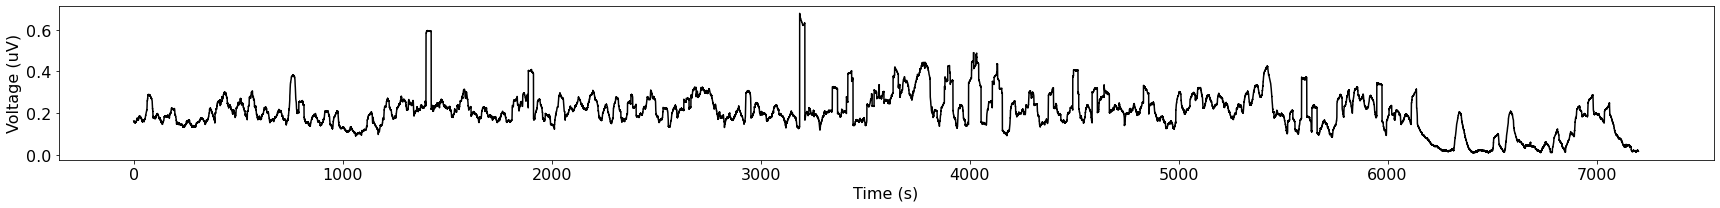

In [66]:
_, ax = plt.subplots(figsize=(24, 3))
plot_time_series(emg.time.values, emg.values, ax=ax)
#plot_hypnogram_overlay(hypno, ax=ax)

### Save

In [67]:
emg_ds = xr.Dataset({"emg": emg})

In [68]:
emg_ds.to_netcdf(paths.get_datapath(subject=SUBJECT, condition=CONDITION, data="emg.nc"))

In [69]:
emg_ds.close()